## Loading of Miller ECoG data of faces/houses (+ noise)

includes some visualizations

In [ ]:
# @title Data retrieval
import os, requests

fname = 'faceshouses.npz'
url = "https://osf.io/argh7/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# @title Install packages (`nilearn`, `nimare`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here.
dat1 = alldat[1][0]
dat2 = alldat[1][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['stim_id', 'stim_cat', 'stim_noise', 't_on', 't_off', 'key_press', 'V', 'categories', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. We plan to curate a few more before NMA starts. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`alldat` contains 7 subjects each with two sessions `dat1` and `dat2`, and was originally used in these publications:

*Miller, Kai J., et al. "Face percept formation in human ventral temporal cortex." Journal of neurophysiology 118.5 (2017): 2614-2627.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

*Miller, Kai J., et al. "The physiology of perception in human temporal lobe is specialized for contextual novelty." Journal of neurophysiology 114.1 (2015): 256-263.*

*Miller, Kai J., et al. "Spontaneous decoding of the timing and content of human object perception from cortical surface recordings reveals complementary information in the event-related potential and broadband spectral change." PLoS computational biology 12.1 (2016): e1004660.*

In this task, subjects in a clinical settings (with ECoG implants) are passively shown faces and house during the first experiment (`dat1`). Then in the second experiment in the same subjects (`dat2`), noise is added to face and houses images and the subject has to detect the faces by pressing a key. Two of the subjects don't have keypresses.

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size.

Experiment 1:
* `dat1['V']`: continuous voltage data (time by channels)
* `dat1['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat1['t_on']`: time of stimulus onset in data samples
* `dat1['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat1['stim_id`]: identity of stimulus from 1-100, with 1-50 being houses and 51-100 being faces
* `dat1['locs`]: 3D electrode positions on the brain surface

Experiment 2:
* `dat2['V`]: continuous voltage data (time by channels)
* `dat2['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.  
* `dat2['t_on']`: time of stimulus onset in data samples
* `dat2['t_off']`: time of stimulus offset, always 1000 samples after `t_on`, with no inter-stimulus interval
* `dat2['stim_id`]: identity of stimulus from 1-600 (not really useful, since we don't know which ones are the same house/face)
* `dat2['stim_cat']`: stimulus category (1 = house, 2 = face)
* `dat2['stim_noise']`: percent noise from 0 to 100
* `dat2['key_press']`: when the subject thought the image was a face
* `dat2['categories']`: categories legend (1 = house, 2 = face)
* `dat2['locs`]: 3D electrode positions on the brain surface


In [ ]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [ ]:
# quick way to get broadband power in time-varying windows
from scipy import signal

V = dat1['V'].astype('float32')

b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

V = V/V.mean(0)

In [ ]:
# average the broadband power across all face stimuli and across all house stimuli

nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(-200, 400)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 600, nchan))

V_house = (V_epochs[dat1['stim_id'] <= 50]).mean(0)
V_face = (V_epochs[dat1['stim_id'] > 50]).mean(0)

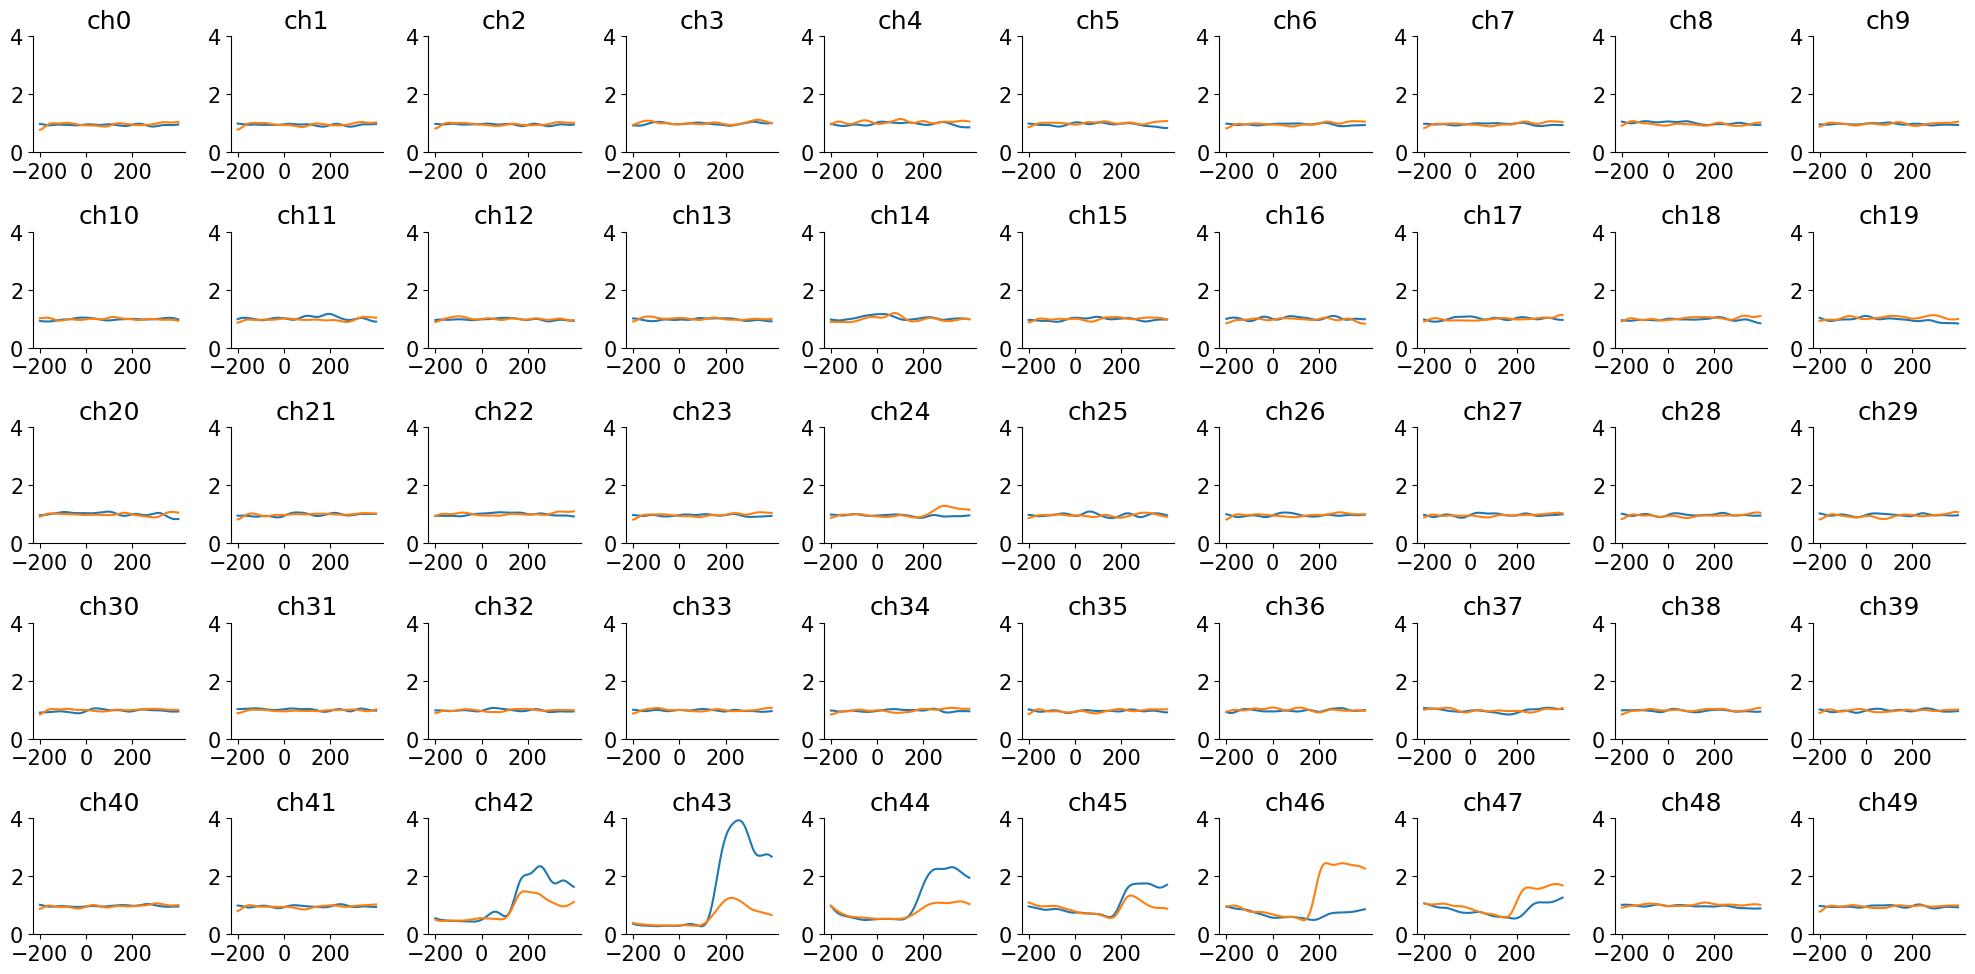

In [ ]:
# let's find the electrodes that distinguish faces from houses
plt.figure(figsize=(20, 10))
for j in range(50):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_house[:, j])
  plt.plot(trange, V_face[:, j])
  plt.title('ch%d'%j)
  plt.xticks([-200, 0, 200])
  plt.ylim([0, 4])
plt.show()

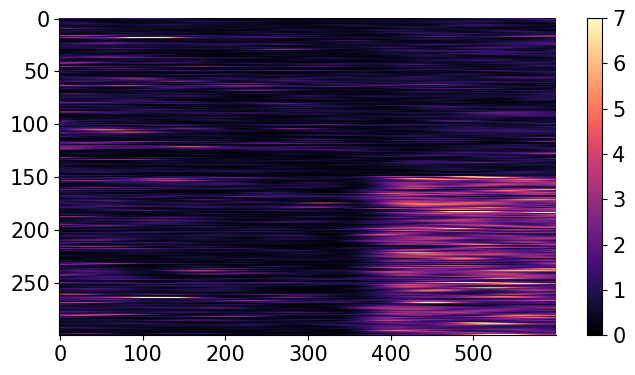

In [ ]:
# let's look at all the face trials for electrode 46 that has a good response to faces
# we will sort trials by stimulus id (1-50 is houses, 51-100 is faces)
plt.subplot(1, 3, 1)
isort = np.argsort(dat1['stim_id'])
plt.imshow(V_epochs[isort, :, 46].astype('float32'),
           aspect='auto', vmax=7, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

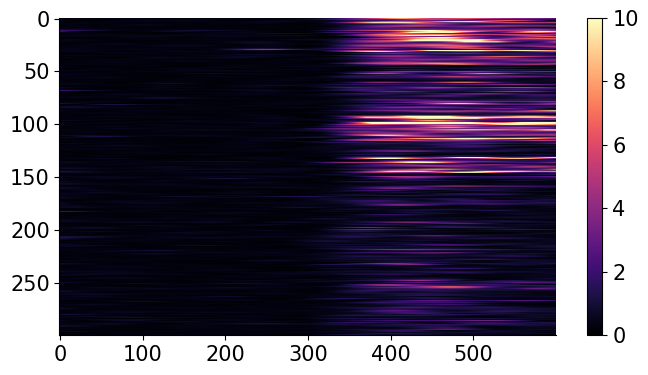

In [ ]:
# Electrode 43 seems to respond to houses
isort = np.argsort(dat1['stim_id'])
plt.subplot(1, 3, 1)
plt.imshow(V_epochs[isort, :, 43].astype('float32'),
           aspect='auto', vmax=10, vmin=0,
           cmap='magma')
plt.colorbar()
plt.show()

In [ ]:
# note, we are using power as a measure of response bc power is voltage squared,
# and this means we don't have to worry about
# negative values messing with things...

from dataclasses import dataclass
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal

@dataclass
class PowerResponse:
    id: str # can be 'face' or 'house'
    power: np.array # power values across the 400 samples
    var: float # variance of the response from 200-400 samples
    auc: float # area under the curve
    std_1: float # standard deviation of the first derivative
    std_2: float # standard deviation of the second derivative
    mean: float # mean response in the trial

@dataclass
class BehaviorResponse:
    patient: int # patient ID (0–6)
    id: int # can be 'face' or 'house' denotes the actual stimulus id
    power: np.array # the max power of that trial
    var: float # variance of the response from 200-400 samples
    auc: float # area under the curve
    std_1: float # standard deviation of the first derivative
    std_2: float # standard deviation of the second derivative
    mean: float # mean power of that trial
    behav: int # 1 if face was identified, 0 otherwise

# TASK 1 :: Create an array of PowerResponses for data in experiment #1
(patients reacting houses vs faces, no behavior responses recorded)



In [ ]:
# Defining Helper Functions ----------------------------------------------------
def create_patient_power_responses(patient: int, channel: int,
                                     database: np.ndarray) -> list[PowerResponse]:
    """
    Takes in a patient number, a channel number, and the database, and returns a list of PowerResponse objects for that specific patient and experiment 1 data.
    """
    exp1_data = database[patient][0]  # Get exp1 data for the specified patient
    voltage_data = exp1_data['V'].T[channel] # voltage data from the correct channel
    power_data = convert_to_power(voltage_data) # function that converts the noisy voltage data to power data

    power_responses = make_list_powerresponses(
        power_data,  # power data from the correct channel.
        exp1_data['t_on'],    # start times (indices)
        exp1_data['t_off'],   # stop times (indices)
        exp1_data['stim_id']  # stimulus ids
    )

    return power_responses

def convert_to_power(voltage_data: np.ndarray) -> np.ndarray:
    """Converts continuous voltage data into a continuous array of power data.
    Applies high-pass and low-pass filtering and normalizes across time."""
    voltage_thirty_two_bit = voltage_data.astype('float32')  # Convert to 32-bit floats
    b, a = signal.butter(3, [50], btype='high', fs=1000)
    V_high_passed = signal.filtfilt(b, a, voltage_thirty_two_bit, 0)
    power_high_passed = np.abs(V_high_passed)**2
    b, a = signal.butter(3, [10], btype='low', fs=1000)
    power_hi_lo_passed = signal.filtfilt(b, a, power_high_passed, 0)
    power_hi_lo_passed_norm = power_hi_lo_passed / power_hi_lo_passed.mean(0)
    return power_hi_lo_passed_norm

def make_list_powerresponses(power_data: np.ndarray, stim_start: np.ndarray, stim_stop: np.ndarray, stim_ids: np.ndarray) -> list[PowerResponse]:
    """
    Extracts power responses for each stimulus trial and returns them as a list of PowerResponse objects. A max power is reported in the power field of the PowerResponse datatype.
    """
    responses = []
    for start, stop, stim_id in zip(stim_start, stim_stop, stim_ids):
      power_slice = power_data[start:stop]
      response_window = power_slice[200:400]

      trial_var = np.var(response_window) # trial var in the 200-400 window sample
      trial_auc = np.trapz(response_window) # area under curve
      trial_mean = np.mean(power_slice) # max power value of the trial

      x = np.arange(0, 200)
      dy_dx = np.gradient(response_window, x)
      d2y_dx2 = np.gradient(dy_dx, x)
      trial_std_1 = np.std(dy_dx)
      trial_std_2 = np.std(d2y_dx2)

      stim_type = "house" if 1 <= stim_id <= 50 else "face"
      responses.append(
        PowerResponse(
          id=stim_type,
          power=power_slice,
          var=trial_var,
          auc=trial_auc,
          std_1=trial_std_1,
          std_2=trial_std_2,
          mean=trial_mean))

    return responses

The variable 'total_responses' in the code below is our output array we wanted! It is an array of PowerResponses from all all seven patients combined, and it is 2100 items long because each patient has 300 data points associated with them, and 300 x 7 is 2100 total data points in our array.

<ipython-input-12-c751ceb1ef5e>:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  trial_auc = np.trapz(response_window) # area under curve


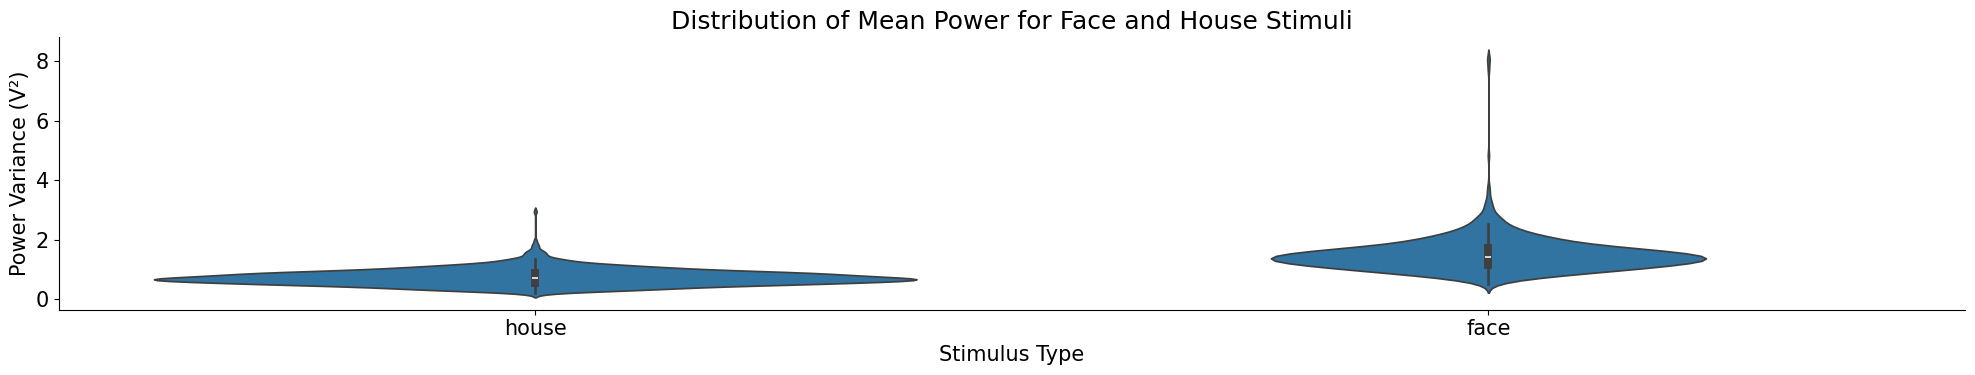

None
mean_faces: 1.5062023571843344, mean_houses: 0.7462683638281459


In [ ]:
# Using above functions to output an array of PowerResponses for all patients.
# Each patient will have 300 trials, and there are 7 patients, so the
# resulting total array of PowerResponses will be 2100 items long.

pat0_resp = create_patient_power_responses(0, 35, alldat)
pat1_resp = create_patient_power_responses(1, 46, alldat)
pat2_resp = create_patient_power_responses(2, 35, alldat)
pat3_resp = create_patient_power_responses(3, 23, alldat)
pat4_resp = create_patient_power_responses(4, 15, alldat)
pat5_resp = create_patient_power_responses(5, 30, alldat)
pat6_resp = create_patient_power_responses(6, 38, alldat)

# !!! The variable total_responses is our array of PowerResponses
# from all seven patients combined !!!
total_responses = pat0_resp + pat1_resp + pat2_resp + pat3_resp + pat4_resp + pat5_resp + pat6_resp

def make_violin_plot(responses: list[PowerResponse]) -> None:
    # Extract scalar power values and corresponding labels
    data = []
    labels = []
    for resp in responses:
        data.append(resp.mean)
        labels.append(resp.id)  # 'face' or 'house'

    df = pd.DataFrame({'Stimulus Type': labels, 'Power Variance': data})

    # Create the violin plot
    sns.violinplot(x='Stimulus Type', y='Power Variance', data=df)
    plt.title('Distribution of Mean Power for Face and House Stimuli')
    plt.xlabel('Stimulus Type')
    plt.ylabel('Power Variance (V²)')
    plt.show()

print(make_violin_plot(total_responses))

# Now we report the average mean power responses from the face trials vs the the house trials:
total_faces = list(filter(lambda x: x.id == 'face', total_responses))
total_houses = list(filter(lambda x: x.id == 'house', total_responses))

mean_faces = np.mean(list(map(lambda x: x.mean, total_faces)))
mean_houses = np.mean(list(map(lambda x: x.mean, total_houses)))

print(f"mean_faces: {mean_faces}, mean_houses: {mean_houses}")

#We see below that the mean power response for faces (3.71 V^2) is higher than that for houses (1.72 V^2). We also see that the violin
#plot for houses is much wider in the x direction. This indicates that for houses, more of the data falls within a
#relatively narrow range (most of the data is pretty close to 1.72 V^2). Meanwhile, the violin plot for faces is
#narrower in the x direction and thicker in the y direction, indicating that the data for faces falls within a wider range
#than for houses (a good chunk of the data falls above or below 3.71 V^2). Part of the issue with this trend
#is that means that a good amount of the face power responses actually fall within the house power response range,
#even if on average the face power reponse is greater than the house. When it comes to trying to figure out how to
#differentiate whether the participant is looking at a face or house, we want power responses from electrodes that are
#very distinct in the majority of cases for face versus house. This graph shows us that we need to keep looking for a
#way to effectively determine the visual stimulus from the electrode data.


<ipython-input-12-c751ceb1ef5e>:42: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  trial_auc = np.trapz(response_window) # area under curve


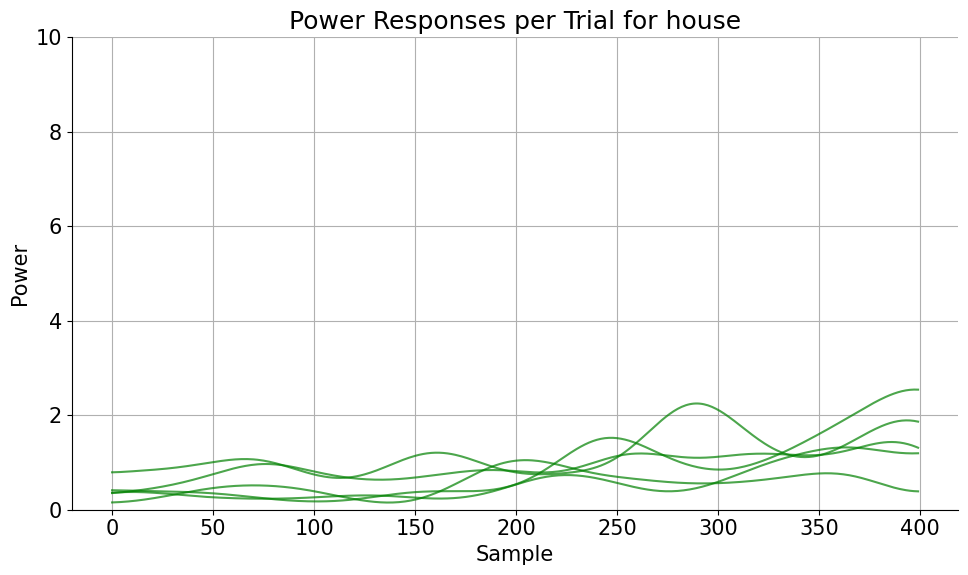

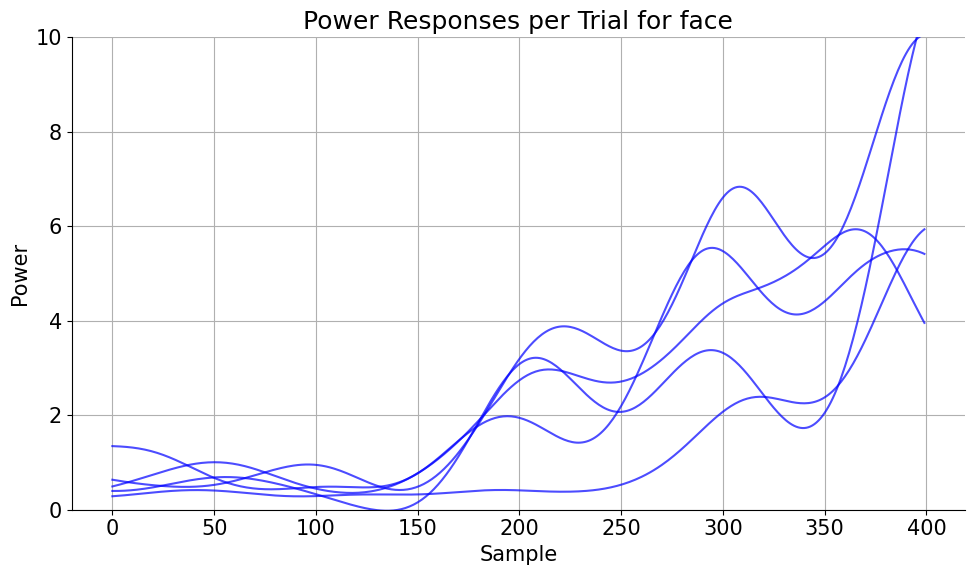

In [ ]:
# Filtering out 5 face trials and 5 house trials to see how the data from exp 1 looks:

pat0_resp = create_patient_power_responses(0, 35, alldat)
pat1_resp = create_patient_power_responses(1, 46, alldat)
pat2_resp = create_patient_power_responses(2, 35, alldat)
pat3_resp = create_patient_power_responses(3, 23, alldat)
pat4_resp = create_patient_power_responses(4, 15, alldat)
pat5_resp = create_patient_power_responses(5, 30, alldat)
pat6_resp = create_patient_power_responses(6, 38, alldat)

total_responses = pat0_resp + pat1_resp + pat2_resp + pat3_resp + pat4_resp + pat5_resp + pat6_resp

face_trials = list(filter(lambda x: x.id == 'face', total_responses))
house_trials = list(filter(lambda x: x.id == 'house', total_responses))

five_house_trials = house_trials[:5]
five_face_trials = face_trials[:5]

def plot_power_responses(responses: list[PowerResponse]) -> None:
    plt.figure(figsize=(10, 6))

    # Optional: color by category
    color_map = {'face': 'blue', 'house': 'green'}

    for idx, response in enumerate(responses):
        x = range(len(response.power))
        y = response.power
        label = f"{response.id} #{idx}"
        color = color_map.get(response.id, 'gray')
        plt.plot(x, y, label=label, color=color, alpha=0.7)

    plt.xlabel('Sample')
    plt.ylabel('Power')
    plt.title('Power Responses per Trial' + ' for ' + responses[0].id)
    #plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(0,10)
    plt.show()

plot_power_responses(five_house_trials)
plot_power_responses(five_face_trials)

In [ ]:
# Plotting 3D Response Space for Experiment #1:
import plotly.graph_objects as go

def make_3d_plotly_plot(responses: list[PowerResponse]) -> None:
    # Separate data by stimulus type
    face_responses = [r for r in responses if r.id == 'face']
    house_responses = [r for r in responses if r.id == 'house']

    # Extract coordinates
    def extract_coords(resp_list):
        return (
            [r.var for r in resp_list],  # x: variance
            [r.auc for r in resp_list],  # y: AUC
            [r.mean for r in resp_list]   # z: max power
        )

    x_face, y_face, z_face = extract_coords(face_responses)
    x_house, y_house, z_house = extract_coords(house_responses)

    fig = go.Figure()

    # Face points
    fig.add_trace(go.Scatter3d(
        x=x_face, y=y_face, z=z_face,
        mode='markers',
        marker=dict(size=3, color='orange'),
        name='Face'
    ))

    # House points
    fig.add_trace(go.Scatter3d(
        x=x_house, y=y_house, z=z_house,
        mode='markers',
        marker=dict(size=3, color='blue'),
        name='House'
    ))

    fig.update_layout(
        title="Interactive 3D Feature Space: Face vs. House Trials, Exp #1",
        scene=dict(
            xaxis_title='Variance (200–400 samples)',
            yaxis_title='AUC (200–400 samples)',
            zaxis_title='Mean Power (V^2)',
        ),
        legend=dict(x=0.02, y=0.98),
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig.show()
def remove_outliers_hard(responses: list[PowerResponse], auc_limit=1500, var_limit=10) -> list[PowerResponse]:
    return [r for r in responses if r.auc <= auc_limit and r.var <= var_limit]

cleaned_responses = remove_outliers_hard(total_responses)

make_3d_plotly_plot(cleaned_responses)

# TASK 2 :: Create an array of BehaviorResponses for data in experiment #2

In [ ]:
# Defining Functions:

def create_patient_behavior_responses(patient: int, channel: int,
                                     database: np.ndarray) -> list[BehaviorResponse]:
    """
    Takes in a patient number, a channel number, and the database, and returns a list of BehaviorResponse objects for that specific patient and experiment 2 data.
    """
    exp2_data = database[patient][1]  # Get exp2 data for the specified patient
    voltage_data = exp2_data['V'].T[channel] # voltage data from the correct channel
    power_data = convert_to_power(voltage_data) # function that converts the noisy voltage data to power data

    behavior_responses = make_list_behaviorresponses(
        patient, # feed in the patient index data to this func
        power_data,  # power data from the correct channel.
        exp2_data['t_on'],    # start times (indices)
        exp2_data['t_off'],   # stop times (indices)
        exp2_data['key_press'], # times when the subject thought the image was a face
        exp2_data['stim_cat']  # stimulus ids
    )

    return behavior_responses

def make_list_behaviorresponses(patient: int, power_data: np.ndarray, stim_start: np.ndarray, stim_stop: np.ndarray, key_presses: np.ndarray, stim_cats: np.ndarray, ) -> list[BehaviorResponse]:
    """
    Extracts behavior responses for each stimulus trial and returns them as a list of BehaviorResponse objects. A max power is reported in the power field of the Behavior datatype.
    """
    responses = []
    for start, stop, key_press, stim_cat in zip(stim_start, stim_stop, key_presses, stim_cats):
      power_slice = power_data[start:stop]
      response_window = power_slice[200:400]
      stim_type = 1 if 2 == stim_cat else 0 # 2 means stimulus was a face, 1 means stimulus was a house. Would like 1 to count as a face stimulus, and 0 to count as a house stimulus.
      face_resp = int(np.any((key_presses >= start) & (key_presses <= stop)))
      # face_resp is 1 if a face was identified and 0 if not

      trial_var = np.var(response_window)
      trial_auc = np.trapz(response_window) # area under curve
      trial_mean = np.max(response_window)

      x = np.arange(0, 200)
      dy_dx = np.gradient(response_window, x)
      d2y_dx2 = np.gradient(dy_dx, x)
      trial_std_1 = np.std(dy_dx)
      trial_std_2 = np.std(d2y_dx2)

      responses.append(
        BehaviorResponse(
        patient=patient,
        id=stim_type,
        power=power_slice,
        var=trial_var,
        auc=trial_auc,
        mean=trial_mean,
        std_1=trial_std_1,
        std_2=trial_std_2,
        behav=face_resp))

    return responses

def convert_to_power(voltage_data: np.ndarray) -> np.ndarray:
    """ Converts continuous voltage data into a continuous array of power data.
    Applies high-pass and low-pass filtering and normalizes across time."""
    voltage_thirty_two_bit = voltage_data.astype('float32')  # Convert to 32-bit floats
    b, a = signal.butter(3, [50], btype='high', fs=1000)
    V_high_passed = signal.filtfilt(b, a, voltage_thirty_two_bit, 0)
    power_high_passed = np.abs(V_high_passed)**2
    b, a = signal.butter(3, [10], btype='low', fs=1000)
    power_hi_lo_passed = signal.filtfilt(b, a, power_high_passed, 0)
    power_hi_lo_passed_norm = power_hi_lo_passed / power_hi_lo_passed.mean(0)
    return power_hi_lo_passed_norm


#----------------------------------------
# Generating our nice array of behavioral responses:

pat0_resp = create_patient_behavior_responses(0, 35, alldat)
pat1_resp = create_patient_behavior_responses(1, 46, alldat)
pat2_resp = create_patient_behavior_responses(2, 35, alldat)
pat3_resp = create_patient_behavior_responses(3, 23, alldat)
pat4_resp = create_patient_behavior_responses(4, 15, alldat)
pat5_resp = create_patient_behavior_responses(5, 30, alldat)
pat6_resp = create_patient_behavior_responses(6, 38, alldat)

total_behav_responses = pat0_resp + pat1_resp + pat2_resp + pat3_resp + pat4_resp + pat5_resp + pat6_resp


<ipython-input-16-cf493a00e10a>:36: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



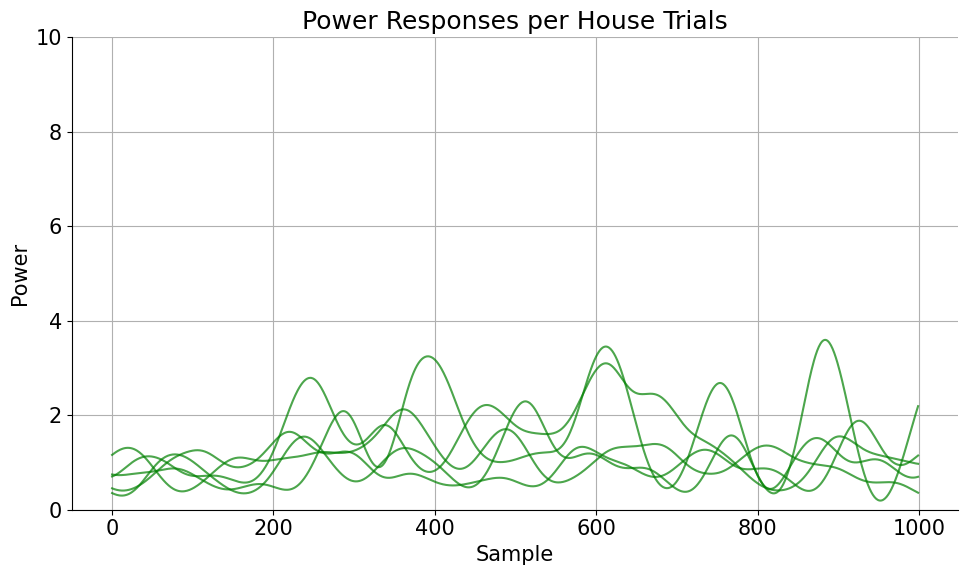

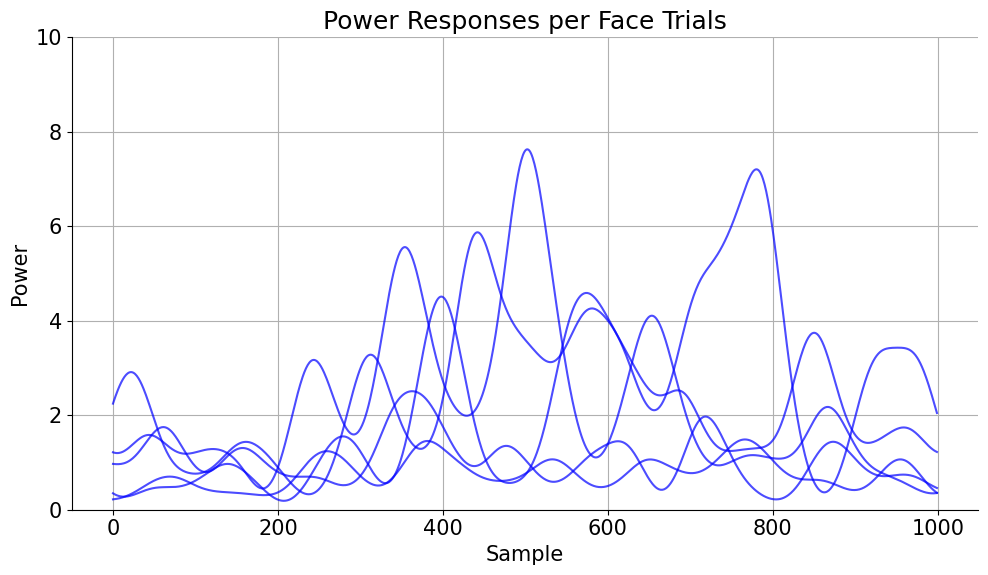

In [ ]:
# Looking at certain trials for faces and houses to see the raw data: (green is house, blue is face)

face_trials = list(filter(lambda x: x.id == 1, total_behav_responses))
house_trials = list(filter(lambda x: x.id == 0, total_behav_responses))

five_house_trials = house_trials[0:5]
five_face_trials = face_trials[0:5]

def plot_power_responses(responses: list[PowerResponse]) -> None:
    plt.figure(figsize=(10, 6))

    # Optional: color by category
    color_map = {'face': 'blue', 'house': 'green'}

    for idx, response in enumerate(responses):
        x = range(len(response.power))
        y = response.power
        label = f"{response.id} #{idx}"
        color = color_map.get(response.id, 'blue' if response.id == 1 else 'green')
        plt.plot(x, y, label=label, color=color, alpha=0.7)

    plt.xlabel('Sample')
    plt.ylabel('Power')
    plt.title('Power Responses per Face Trials' if responses[0].id == 1 else 'Power Responses per House Trials')
    #plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.ylim(0,10)
    plt.show()

plot_power_responses(five_house_trials)
plot_power_responses(five_face_trials)

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import pandas as pd
import statsmodels.api as sm

# Filtering our total list to only contain face trials with an adequate response:

# Our hypothesis is trying to investigate whether a neuronal response is a good predictor of behavior, so
# let's filter out the neuronal response trials to faces that have a reasonable-sized response:
def filter_responses_by_auc(responses: list[BehaviorResponse], threshold: int) -> list[BehaviorResponse]:
    """
    Keeps all house trials (id=0), and only keeps face trials (id=1)
    if their AUC is greater than the specified threshold.
    """
    return [
        r for r in responses
        if r.id == 0 or (r.id == 1 and r.auc > threshold)
        # keep the response if it is a house trial, or if it is a face trial that has a response above a certain threshold.
    ]

filtered_behav_responses = filter_responses_by_auc(total_behav_responses, threshold=350)


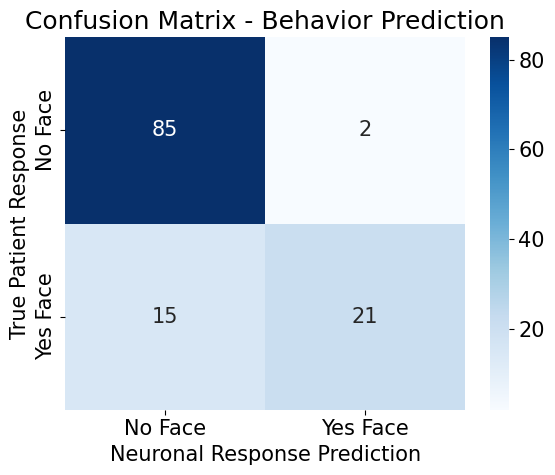

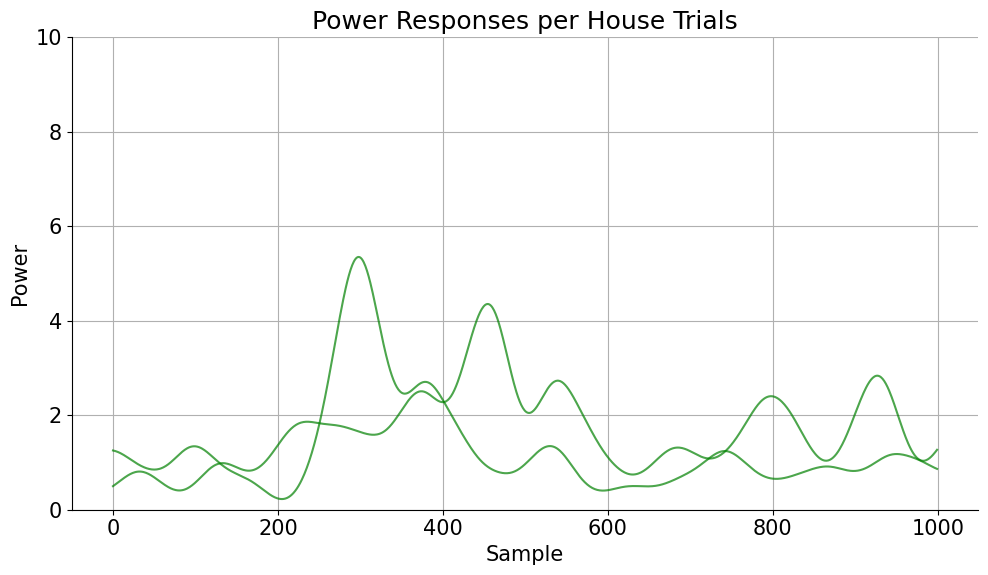

Accuracy: 0.8617886178861789
Confusion matrix:
 [[85  2]
 [15 21]]


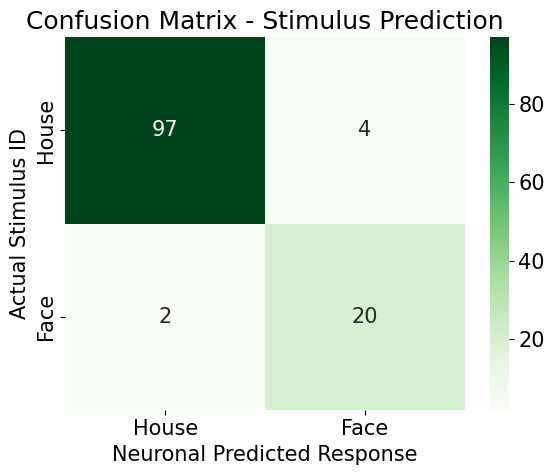

Accuracy: 0.9512195121951219
Confusion matrix:
 [[97  4]
 [ 2 20]]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# Prepare feature matrix and labels
X = np.array([[r.var, r.auc, r.mean, r.std_1, r.std_2] for r in filtered_behav_responses])
y = np.array([1 if r.behav == 1 else 0 for r in filtered_behav_responses])
all_indices = np.arange(len(filtered_behav_responses))

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, all_indices, test_size=0.2, stratify=y)

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Face", "Yes Face"], yticklabels=["No Face", "Yes Face"])
plt.title("Confusion Matrix - Behavior Prediction")
plt.xlabel("Neuronal Response Prediction")
plt.ylabel("True Patient Response")
plt.show()

#----------------
# Identifying and print false positives (when Neuronal Response was yes, but patient response was no)
false_positives = (y_test == 0) & (y_pred == 1)  # predicted behavior, but no actual behavior

false_pos_indices = idx_test[false_positives]  # map back to original data

false_pos_trials = [filtered_behav_responses[i] for i in false_pos_indices]

plot_power_responses(false_pos_trials)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

#----------------------------------------------------------------

# for actual id of the stimulus as opposed to behavior
X = np.array([[r.var, r.auc, r.mean, r.std_1, r.std_2] for r in filtered_behav_responses])
y = np.array([1 if r.id == 1 else 0 for r in filtered_behav_responses])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LogisticRegression().fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["House", "Face"], yticklabels=["House", "Face"])
plt.title("Confusion Matrix - Stimulus Prediction")
plt.xlabel("Neuronal Predicted Response")
plt.ylabel("Actual Stimulus ID")
plt.show()

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))